In [1]:
# !pip install pylibjpeg
# !pip install --upgrade numpy
#!pip install python-gdcm
#!pip install pylibjpeg pylibjpeg-libjpeg

In [2]:
#!pip install pydicom
#!pip install nibabel

In [3]:
#od.download("https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection")

In [4]:
# !pip install timm
# !pip install git+https://github.com/qubvel/segmentation_models.pytorch
# !pip install monai

In [5]:
import segmentation_models_pytorch as smp
#check if you have imported the correct version

smp.__version__

'0.3.2'

In [6]:
DEBUG = False

import os
import sys
sys.path = [
    'covn3d-same',
] + sys.path

In [7]:
import opendatasets as od
import os
import sys
import gc
import ast
import cv2
import time
import timm
import pickle
import random
import pydicom
import argparse
import warnings
import numpy as np
import pandas as pd
from glob import glob
import nibabel as nib
from PIL import Image
from tqdm import tqdm
import albumentations
from pylab import rcParams
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from sklearn.model_selection import KFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from monai.transforms import Resize
import  monai.transforms as transforms

%matplotlib inline
rcParams['figure.figsize'] = 20, 8
device = torch.device('cuda')
#device=torch.cuda.set_device(1)
torch.backends.cudnn.benchmark = True

In [8]:
#!pip install pydicom
#!pip install nibabel
#!pip install albumentations

## Config

In [9]:
kernel_type = 'timm3d_res18d_unet4b_128_128_128_dsv2_flip12_shift333p7_gd1p5_bs4_lr3e4_20x50ep'
load_kernel = None
load_last = True
n_blocks = 4
n_folds = 5
backbone = 'resnet18d'

image_sizes = [128, 128, 128]
R = Resize(image_sizes)

init_lr = 3e-3
batch_size = 10
drop_rate = 0.
drop_path_rate = 0.
loss_weights = [1, 1]
p_mixup = 0.1

data_dir = '../RSNA_2022_DATA/rsna-2022-cervical-spine-fracture-detection'
use_amp = True
num_workers = 4
out_dim = 7

n_epochs = 1000

log_dir = './logs'
model_dir = './models'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [10]:
transforms_train = transforms.Compose([
    transforms.RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=1),
    transforms.RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=2),
    transforms.RandAffined(keys=["image", "mask"], translate_range=[int(x*y) for x, y in zip(image_sizes, [0.3, 0.3, 0.3])], padding_mode='zeros', prob=0.7),
    transforms.RandGridDistortiond(keys=("image", "mask"), prob=0.5, distort_limit=(-0.01, 0.01), mode="nearest"),    
])

transforms_valid = transforms.Compose([
])

## DataFrame

In [11]:
data_dir

'../RSNA_2022_DATA/rsna-2022-cervical-spine-fracture-detection'

In [12]:
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))

mask_files = os.listdir(f'{data_dir}/segmentations')
df_mask = pd.DataFrame({
    'mask_file': mask_files,
})
df_mask['StudyInstanceUID'] = df_mask['mask_file'].apply(lambda x: x[:-4])
df_mask['mask_file'] = df_mask['mask_file'].apply(lambda x: os.path.join(data_dir, 'segmentations', x))
df = df_train.merge(df_mask, on='StudyInstanceUID', how='left')
df['image_folder'] = df['StudyInstanceUID'].apply(lambda x: os.path.join(data_dir, 'train_images', x))
df['mask_file'].fillna('', inplace=True)

df_seg = df.query('mask_file != ""').reset_index(drop=True)

kf = KFold(5)
df_seg['fold'] = -1
for fold, (train_idx, valid_idx) in enumerate(kf.split(df_seg, df_seg)):
    df_seg.loc[valid_idx, 'fold'] = fold

df_seg.tail()

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7,mask_file,image_folder,fold
82,1.2.826.0.1.3680043.32071,1,0,1,0,1,0,1,1,../RSNA_2022_DATA/rsna-2022-cervical-spine-fra...,../RSNA_2022_DATA/rsna-2022-cervical-spine-fra...,4
83,1.2.826.0.1.3680043.30524,1,0,0,0,0,0,1,1,../RSNA_2022_DATA/rsna-2022-cervical-spine-fra...,../RSNA_2022_DATA/rsna-2022-cervical-spine-fra...,4
84,1.2.826.0.1.3680043.28025,0,0,0,0,0,0,0,0,../RSNA_2022_DATA/rsna-2022-cervical-spine-fra...,../RSNA_2022_DATA/rsna-2022-cervical-spine-fra...,4
85,1.2.826.0.1.3680043.21321,1,1,1,1,0,0,0,1,../RSNA_2022_DATA/rsna-2022-cervical-spine-fra...,../RSNA_2022_DATA/rsna-2022-cervical-spine-fra...,4
86,1.2.826.0.1.3680043.26990,1,0,0,0,0,1,1,1,../RSNA_2022_DATA/rsna-2022-cervical-spine-fra...,../RSNA_2022_DATA/rsna-2022-cervical-spine-fra...,4


## Dataset

In [13]:
revert_list = [
    '1.2.826.0.1.3680043.1363',
    '1.2.826.0.1.3680043.20120',
    '1.2.826.0.1.3680043.2243',
    '1.2.826.0.1.3680043.24606',
    '1.2.826.0.1.3680043.32071'
]

In [14]:
#!pip install pydicom --upgrade
#!pip install pylibjpeg
#!pip install tensorflow
#!pip install tensorflow-io
import pydicom
pydicom.__version__

'2.3.1'

In [15]:
from pydicom import dcmread
import pylibjpeg
import tensorflow as tf
import tensorflow_io as tfio
from PIL import Image
# from pydicom.pixel_data_handlers import pillow_handler
# pillow_handler.PillowJPEGTransferSyntaxes.append('1.2.840.10008.1.2.4.70')

def load_dicom(path):
    dicom = pydicom.read_file(path)    
    #dicom= pydicom.dcmread(path)
    
#     image_bytes = tf.io.read_file(path)
#     image = tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16)
    
    #dicom.PhotometricInterpretation = 'YBR_FULL'
    #dicom.file_meta.TransferSyntaxUID
    #dicom=dicom.decompress(gdcm)
    #data=pydicom.pixel_data_handlers.pillow_handler.get_pixeldata(dicom)
    #data=image
    data = dicom.pixel_array
    data = cv2.resize(data, (image_sizes[0], image_sizes[1]), interpolation = cv2.INTER_LINEAR)
    return data


def load_dicom_line_par(path):

    t_paths = sorted(glob(os.path.join(path, "*")),
       key=lambda x: int(x.split('/')[-1].split(".")[0]))

    n_scans = len(t_paths)
    indices = np.quantile(list(range(n_scans)), np.linspace(0., 1., image_sizes[2])).round().astype(int)
    t_paths = [t_paths[i] for i in indices]

    images = []
    for filename in t_paths:
        images.append(load_dicom(filename))
    images = np.stack(images, -1)
    
    images = images - np.min(images)
    images = images / (np.max(images) + 1e-4)
    images = (images * 255).astype(np.uint8)

    return images


def load_sample(row, has_mask=True):

    image = load_dicom_line_par(row.image_folder)
    if image.ndim < 4:
        image = np.expand_dims(image, 0).repeat(3, 0)  # to 3ch

    if has_mask:
        mask_org = nib.load(row.mask_file).get_fdata()
        shape = mask_org.shape
        mask_org = mask_org.transpose(1, 0, 2)[::-1, :, ::-1]  # (d, w, h)
        mask = np.zeros((7, shape[0], shape[1], shape[2]))
        for cid in range(7):
            mask[cid] = (mask_org == (cid+1))
        mask = mask.astype(np.uint8) * 255
        mask = R(mask).numpy()
        
        return image, mask
    else:
        return image



class SEGDataset(Dataset):
    def __init__(self, df, mode, transform):

        self.df = df.reset_index()
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        
        
        ### using local cache
#         image_file = os.path.join(data_dir, f'{row.StudyInstanceUID}.npy')
#         mask_file = os.path.join(data_dir, f'{row.StudyInstanceUID}_mask.npy')
#         image = np.load(image_file).astype(np.float32)
#         mask = np.load(mask_file).astype(np.float32)

        image, mask = load_sample(row, has_mask=True)
    
        if row.StudyInstanceUID in revert_list:
            mask = mask[:, :, :, ::-1]

        res = self.transform({'image':image, 'mask':mask})
        image = res['image'] / 255.
        mask = res['mask']
        mask = (mask > 127).astype(np.int8)

        image, mask = torch.tensor(image).int(), torch.tensor(mask).int()

        return image, mask


2023-01-13 11:27:28.532225: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-13 11:27:29.200015: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/apaddo/.local/lib/python3.9/site-packages/cv2/../../lib64:
2023-01-13 11:27:29.200105: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/apaddo/.local/lib/python3.9/site-packages/cv2/../../lib64:


In [16]:
rcParams['figure.figsize'] = 20,8

df_show = df_seg
dataset_show = SEGDataset(df_show, 'train', transform=transforms_train)

In [17]:
# dataset_show[1]

/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()


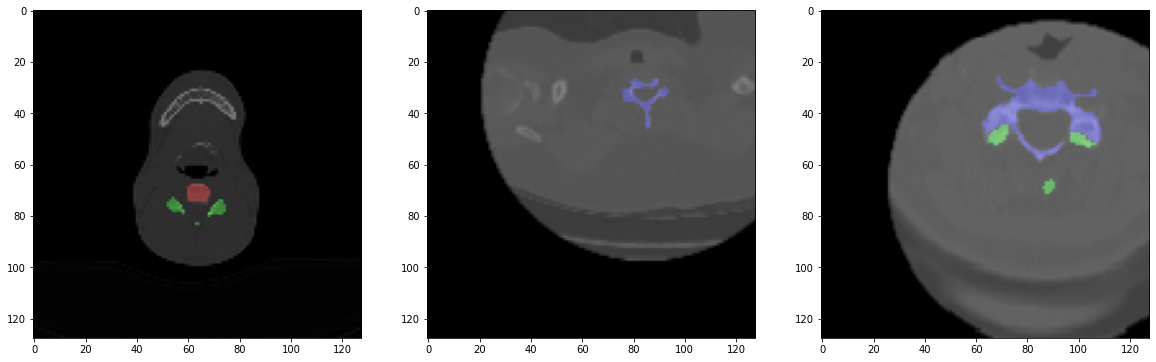

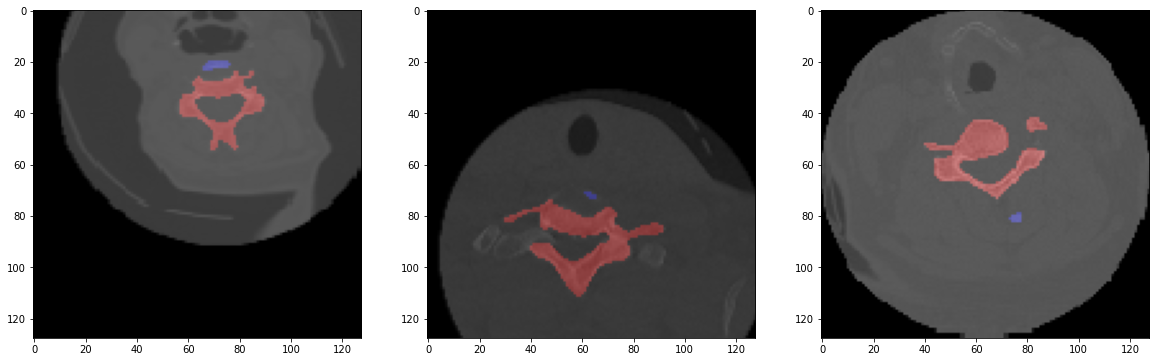

In [18]:
for i in range(2):
    f, axarr = plt.subplots(1,3)
    for p in range(3):
        idx = i*4+p
        img, mask = dataset_show[idx]
        img = img[:, :, :, 60]
        mask = mask[:, :, :, 60]
        mask[0] = mask[0] + mask[3] + mask[6]
        mask[1] = mask[1] + mask[4]
        mask[2] = mask[2] + mask[5]
        mask = mask[:3]
        img = img * 0.7 + mask * 0.3
        axarr[p].imshow(img.transpose(0, 1).transpose(1,2).squeeze())

## Model

In [19]:
pydicom.__version__

'2.3.1'

In [20]:
class TimmSegModel(nn.Module):
    def __init__(self, backbone, segtype='unet', pretrained=False):
        super(TimmSegModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=3,
            features_only=True,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate,
            pretrained=pretrained
        )
        g = self.encoder(torch.rand(1, 3, 64, 64))
        encoder_channels = [1] + [_.shape[1] for _ in g]
        decoder_channels = [256, 128, 64, 32, 16]
        if segtype == 'unet':
            #self.decoder = smp.unet.decoder.UnetDecoder(
            #self.decoder = smp.UnetDecoder(
            #self.decoder = smp.Unet(
            self.decoder = smp.decoders.unet.decoder.UnetDecoder(
                encoder_channels=encoder_channels[:n_blocks+1],
                decoder_channels=decoder_channels[:n_blocks],
                n_blocks=n_blocks,
            )

        self.segmentation_head = nn.Conv2d(decoder_channels[n_blocks-1], out_dim, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    def forward(self,x):
        global_features = [0] + self.encoder(x)[:n_blocks]
        seg_features = self.decoder(*global_features)
        seg_features = self.segmentation_head(seg_features)
        return seg_features

In [21]:
from timm.models.layers.conv2d_same import Conv2dSame
from conv3d_same import Conv3dSame


def convert_3d(module):

    module_output = module
    if isinstance(module, torch.nn.BatchNorm2d):
        module_output = torch.nn.BatchNorm3d(
            module.num_features,
            module.eps,
            module.momentum,
            module.affine,
            module.track_running_stats,
        )
        if module.affine:
            with torch.no_grad():
                module_output.weight = module.weight
                module_output.bias = module.bias
        module_output.running_mean = module.running_mean
        module_output.running_var = module.running_var
        module_output.num_batches_tracked = module.num_batches_tracked
        if hasattr(module, "qconfig"):
            module_output.qconfig = module.qconfig
            
    elif isinstance(module, Conv2dSame):
        module_output = Conv3dSame(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.Conv2d):
        module_output = torch.nn.Conv3d(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
            padding_mode=module.padding_mode
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.MaxPool2d):
        module_output = torch.nn.MaxPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            dilation=module.dilation,
            ceil_mode=module.ceil_mode,
        )
    elif isinstance(module, torch.nn.AvgPool2d):
        module_output = torch.nn.AvgPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            ceil_mode=module.ceil_mode,
        )

    for name, child in module.named_children():
        module_output.add_module(
            name, convert_3d(child)
        )
    del module

    return module_output


m = TimmSegModel(backbone)
m = convert_3d(m)
m(torch.rand(1, 3, 128,128,128)).shape
m = m.to(device)

## Loss & Metric

In [22]:
from typing import Any, Dict, Optional


def binary_dice_score(
    y_pred: torch.Tensor,
    y_true: torch.Tensor,
    threshold: Optional[float] = None,
    nan_score_on_empty=False,
    eps: float = 1e-7,
) -> float:

    if threshold is not None:
        y_pred = (y_pred > threshold).to(y_true.dtype)

    intersection = torch.sum(y_pred * y_true).item()
    cardinality = (torch.sum(y_pred) + torch.sum(y_true)).item()

    score = (2.0 * intersection) / (cardinality + eps)

    has_targets = torch.sum(y_true) > 0
    has_predicted = torch.sum(y_pred) > 0

    if not has_targets:
        if nan_score_on_empty:
            score = np.nan
        else:
            score = float(not has_predicted)
    return score


def multilabel_dice_score(
    y_true: torch.Tensor,
    y_pred: torch.Tensor,
    threshold=None,
    eps=1e-7,
    nan_score_on_empty=False,
):
    ious = []
    num_classes = y_pred.size(0)
    for class_index in range(num_classes):
        iou = binary_dice_score(
            y_pred=y_pred[class_index],
            y_true=y_true[class_index],
            threshold=threshold,
            nan_score_on_empty=nan_score_on_empty,
            eps=eps,
        )
        ious.append(iou)

    return ious


def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return 1 - ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


def bce_dice(input, target, loss_weights=loss_weights):
    loss1 = loss_weights[0] * nn.BCEWithLogitsLoss()(input, target)
    loss2 = loss_weights[1] * dice_loss(input, target)
    return (loss1 + loss2) / sum(loss_weights)

criterion = bce_dice

## Train & Valid func

In [23]:
def mixup(input, truth, clip=[0, 1]):
    indices = torch.randperm(input.size(0))
    shuffled_input = input[indices]
    shuffled_labels = truth[indices]

    lam = np.random.uniform(clip[0], clip[1])
    input = input * lam + shuffled_input * (1 - lam)
    return input, truth, shuffled_labels, lam


def train_func(model, loader_train, optimizer, scaler=None):
    model.train()
    model = model.to(device)
    train_loss = []
    bar = tqdm(loader_train)
    for images, gt_masks in bar:
        optimizer.zero_grad()
        #images = images.cuda()
        #gt_masks = gt_masks.cuda()
        images = images.to(device)
        gt_masks = gt_masks.to(device)

        do_mixup = False
        if random.random() < p_mixup:
            do_mixup = True
            images, gt_masks, gt_masks_sfl, lam = mixup(images, gt_masks)

        with amp.autocast():
            logits = model(images)
            loss = criterion(logits, gt_masks)
            if do_mixup:
                loss2 = criterion(logits, gt_masks_sfl)
                loss = loss * lam  + loss2 * (1 - lam)

        train_loss.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bar.set_description(f'smth:{np.mean(train_loss[-30:]):.4f}')

    return np.mean(train_loss)


def valid_func(model, loader_valid):
    model.eval()
    valid_loss = []
    outputs = []
    ths = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    batch_metrics = [[]] * 7
    bar = tqdm(loader_valid)
    with torch.no_grad():
        for images, gt_masks in bar:
            images = images.cuda()
            gt_masks = gt_masks.cuda()

            logits = model(images)
            loss = criterion(logits, gt_masks)
            valid_loss.append(loss.item())
            for thi, th in enumerate(ths):
                pred = (logits.sigmoid() > th).float().detach()
                for i in range(logits.shape[0]):
                    tmp = multilabel_dice_score(
                        y_pred=logits[i].sigmoid().cpu(),
                        y_true=gt_masks[i].cpu(),
                        threshold=0.5,
                    )
                    batch_metrics[thi].extend(tmp)
            bar.set_description(f'smth:{np.mean(valid_loss[-30:]):.4f}')
            
    metrics = [np.mean(this_metric) for this_metric in batch_metrics]
    print('best th:', ths[np.argmax(metrics)], 'best dc:', np.max(metrics))

    return np.mean(valid_loss), np.max(metrics)


/home/apaddo/.local/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/home/apaddo/.local/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use cas

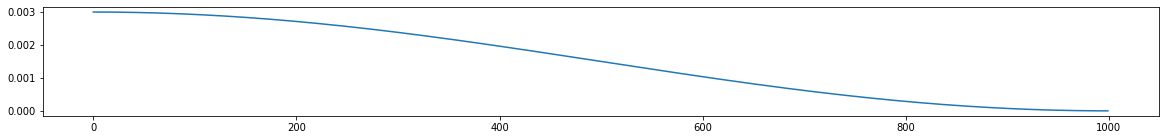

In [24]:
rcParams['figure.figsize'] = 20, 2
optimizer = optim.AdamW(m.parameters(), lr=init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1000)
lrs = []
for epoch in range(1, 1000+1):
    scheduler_cosine.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
plt.plot(range(len(lrs)), lrs)

## Training

## Quantization-aware training

In [25]:
def run(fold):

    log_file = os.path.join(log_dir, f'{kernel_type}.txt')
    model_file = os.path.join(model_dir, f'{kernel_type}_fold{fold}_best.pth')

    train_ = df_seg[df_seg['fold'] != fold].reset_index(drop=True)
    valid_ = df_seg[df_seg['fold'] == fold].reset_index(drop=True)
    dataset_train = SEGDataset(train_, 'train', transform=transforms_train)
    dataset_valid = SEGDataset(valid_, 'valid', transform=transforms_valid)
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = TimmSegModel(backbone, pretrained=True)
    model = convert_3d(model)
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=init_lr)
    scaler = torch.cuda.amp.GradScaler()
    from_epoch = 0
    metric_best = 0.
    loss_min = np.inf

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, n_epochs)
    
    model = torch.quantization.convert(model.eval(), inplace=False)
    
    optimizer = torch.optim.SGD(model.parameters(), lr = 3e-3)
    model.qconfig = torch.ao.quantization.get_default_qat_qconfig('fbgemm')
    
    #torch.ao.quantization.prepare_qat(model, inplace=True)

    print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, n_epochs+1):
        scheduler_cosine.step(epoch-1)

        print(time.ctime(), 'Epoch:', epoch)

        train_loss = train_func(model, loader_train, optimizer, scaler)
        valid_loss, metric = valid_func(model, loader_valid)

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, metric: {(metric):.6f}.'
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric > metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
            torch.save(model.state_dict(), model_file)
            metric_best = metric

        # Save Last
        if not DEBUG:
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scaler_state_dict': scaler.state_dict() if scaler else None,
                    'score_best': metric_best,
                },
                model_file.replace('_best', '_last')
            )

    del model
    torch.cuda.empty_cache()
    gc.collect()




In [26]:
from logging import DEBUG

In [ ]:
run(0)

2023-01-13 11:28:11,270 - Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet18d_ra2-48a79e06.pth)
69 18
Fri Jan 13 11:28:11 2023 Epoch: 1


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.005013113915664389
Fri Jan 13 11:33:35 2023 Fold 0, Epoch 1, lr: 0.0030000, train loss: 1.05326, valid loss: 1.19004, metric: 0.005013.
metric_best (0.000000 --> 0.005013). Saving model ...
Fri Jan 13 11:33:35 2023 Epoch: 2


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00502300658269447
Fri Jan 13 11:38:42 2023 Fold 0, Epoch 2, lr: 0.0030000, train loss: 1.02468, valid loss: 0.99819, metric: 0.005023.
metric_best (0.005013 --> 0.005023). Saving model ...
Fri Jan 13 11:38:42 2023 Epoch: 3


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.005030908895308907
Fri Jan 13 11:43:53 2023 Fold 0, Epoch 3, lr: 0.0030000, train loss: 0.99579, valid loss: 0.96778, metric: 0.005031.
metric_best (0.005023 --> 0.005031). Saving model ...
Fri Jan 13 11:43:53 2023 Epoch: 4


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.005047607310144328
Fri Jan 13 11:49:05 2023 Fold 0, Epoch 4, lr: 0.0030000, train loss: 0.96807, valid loss: 0.94892, metric: 0.005048.
metric_best (0.005031 --> 0.005048). Saving model ...
Fri Jan 13 11:49:05 2023 Epoch: 5


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.005092219668214937
Fri Jan 13 11:54:10 2023 Fold 0, Epoch 5, lr: 0.0030000, train loss: 0.94522, valid loss: 0.93065, metric: 0.005092.
metric_best (0.005048 --> 0.005092). Saving model ...
Fri Jan 13 11:54:11 2023 Epoch: 6


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.005100408618732812
Fri Jan 13 11:59:26 2023 Fold 0, Epoch 6, lr: 0.0030000, train loss: 0.92252, valid loss: 0.91075, metric: 0.005100.
metric_best (0.005092 --> 0.005100). Saving model ...
Fri Jan 13 11:59:26 2023 Epoch: 7


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.005113360954027696
Fri Jan 13 12:04:45 2023 Fold 0, Epoch 7, lr: 0.0030000, train loss: 0.90244, valid loss: 0.89450, metric: 0.005113.
metric_best (0.005100 --> 0.005113). Saving model ...
Fri Jan 13 12:04:45 2023 Epoch: 8


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.005130248192938358
Fri Jan 13 12:09:43 2023 Fold 0, Epoch 8, lr: 0.0030000, train loss: 0.88247, valid loss: 0.87599, metric: 0.005130.
metric_best (0.005113 --> 0.005130). Saving model ...
Fri Jan 13 12:09:44 2023 Epoch: 9


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.005157503790259318
Fri Jan 13 12:14:49 2023 Fold 0, Epoch 9, lr: 0.0030000, train loss: 0.86423, valid loss: 0.85868, metric: 0.005158.
metric_best (0.005130 --> 0.005158). Saving model ...
Fri Jan 13 12:14:49 2023 Epoch: 10


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.005219334446575964
Fri Jan 13 12:19:44 2023 Fold 0, Epoch 10, lr: 0.0030000, train loss: 0.84748, valid loss: 0.84395, metric: 0.005219.
metric_best (0.005158 --> 0.005219). Saving model ...
Fri Jan 13 12:19:44 2023 Epoch: 11


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0053189821143929585
Fri Jan 13 12:24:46 2023 Fold 0, Epoch 11, lr: 0.0030000, train loss: 0.83146, valid loss: 0.82811, metric: 0.005319.
metric_best (0.005219 --> 0.005319). Saving model ...
Fri Jan 13 12:24:47 2023 Epoch: 12


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00542096827815255
Fri Jan 13 12:30:08 2023 Fold 0, Epoch 12, lr: 0.0030000, train loss: 0.81677, valid loss: 0.81395, metric: 0.005421.
metric_best (0.005319 --> 0.005421). Saving model ...
Fri Jan 13 12:30:08 2023 Epoch: 13


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.005531209452629629
Fri Jan 13 12:34:53 2023 Fold 0, Epoch 13, lr: 0.0030000, train loss: 0.80325, valid loss: 0.80029, metric: 0.005531.
metric_best (0.005421 --> 0.005531). Saving model ...
Fri Jan 13 12:34:54 2023 Epoch: 14


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0056105806047777144
Fri Jan 13 12:39:50 2023 Fold 0, Epoch 14, lr: 0.0030000, train loss: 0.79010, valid loss: 0.78732, metric: 0.005611.
metric_best (0.005531 --> 0.005611). Saving model ...
Fri Jan 13 12:39:50 2023 Epoch: 15


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.005696984607693824
Fri Jan 13 12:44:24 2023 Fold 0, Epoch 15, lr: 0.0030000, train loss: 0.77736, valid loss: 0.77507, metric: 0.005697.
metric_best (0.005611 --> 0.005697). Saving model ...
Fri Jan 13 12:44:24 2023 Epoch: 16


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.005759127729824248
Fri Jan 13 12:49:21 2023 Fold 0, Epoch 16, lr: 0.0030000, train loss: 0.76581, valid loss: 0.76360, metric: 0.005759.
metric_best (0.005697 --> 0.005759). Saving model ...
Fri Jan 13 12:49:21 2023 Epoch: 17


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.005848798618536382
Fri Jan 13 12:54:23 2023 Fold 0, Epoch 17, lr: 0.0030000, train loss: 0.75511, valid loss: 0.75289, metric: 0.005849.
metric_best (0.005759 --> 0.005849). Saving model ...
Fri Jan 13 12:54:24 2023 Epoch: 18


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.005936737523006832
Fri Jan 13 12:59:16 2023 Fold 0, Epoch 18, lr: 0.0030000, train loss: 0.74469, valid loss: 0.74305, metric: 0.005937.
metric_best (0.005849 --> 0.005937). Saving model ...
Fri Jan 13 12:59:16 2023 Epoch: 19


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.006010613889154855
Fri Jan 13 13:04:05 2023 Fold 0, Epoch 19, lr: 0.0030000, train loss: 0.73503, valid loss: 0.73345, metric: 0.006011.
metric_best (0.005937 --> 0.006011). Saving model ...
Fri Jan 13 13:04:06 2023 Epoch: 20


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.006110691482364263
Fri Jan 13 13:08:52 2023 Fold 0, Epoch 20, lr: 0.0030000, train loss: 0.72561, valid loss: 0.72435, metric: 0.006111.
metric_best (0.006011 --> 0.006111). Saving model ...
Fri Jan 13 13:08:52 2023 Epoch: 21


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.006150612836221461
Fri Jan 13 13:13:47 2023 Fold 0, Epoch 21, lr: 0.0030000, train loss: 0.71719, valid loss: 0.71620, metric: 0.006151.
metric_best (0.006111 --> 0.006151). Saving model ...
Fri Jan 13 13:13:47 2023 Epoch: 22


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00621350356257516
Fri Jan 13 13:18:43 2023 Fold 0, Epoch 22, lr: 0.0030000, train loss: 0.70863, valid loss: 0.70823, metric: 0.006214.
metric_best (0.006151 --> 0.006214). Saving model ...
Fri Jan 13 13:18:43 2023 Epoch: 23


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.006296622493139223
Fri Jan 13 13:23:29 2023 Fold 0, Epoch 23, lr: 0.0030000, train loss: 0.70123, valid loss: 0.70061, metric: 0.006297.
metric_best (0.006214 --> 0.006297). Saving model ...
Fri Jan 13 13:23:29 2023 Epoch: 24


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0063265803491451686
Fri Jan 13 13:28:17 2023 Fold 0, Epoch 24, lr: 0.0030000, train loss: 0.69364, valid loss: 0.69322, metric: 0.006327.
metric_best (0.006297 --> 0.006327). Saving model ...
Fri Jan 13 13:28:17 2023 Epoch: 25


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.006413586831345775
Fri Jan 13 13:33:10 2023 Fold 0, Epoch 25, lr: 0.0030000, train loss: 0.68688, valid loss: 0.68651, metric: 0.006414.
metric_best (0.006327 --> 0.006414). Saving model ...
Fri Jan 13 13:33:10 2023 Epoch: 26


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.006497302980052855
Fri Jan 13 13:37:54 2023 Fold 0, Epoch 26, lr: 0.0030000, train loss: 0.68035, valid loss: 0.68017, metric: 0.006497.
metric_best (0.006414 --> 0.006497). Saving model ...
Fri Jan 13 13:37:54 2023 Epoch: 27


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.006525402752056353
Fri Jan 13 13:42:43 2023 Fold 0, Epoch 27, lr: 0.0030000, train loss: 0.67403, valid loss: 0.67418, metric: 0.006525.
metric_best (0.006497 --> 0.006525). Saving model ...
Fri Jan 13 13:42:43 2023 Epoch: 28


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00651566467351023
Fri Jan 13 13:47:35 2023 Fold 0, Epoch 28, lr: 0.0030000, train loss: 0.66807, valid loss: 0.66837, metric: 0.006516.
Fri Jan 13 13:47:35 2023 Epoch: 29


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.006492179389214651
Fri Jan 13 13:52:15 2023 Fold 0, Epoch 29, lr: 0.0030000, train loss: 0.66210, valid loss: 0.66247, metric: 0.006492.
Fri Jan 13 13:52:15 2023 Epoch: 30


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00641062193544889
Fri Jan 13 13:56:58 2023 Fold 0, Epoch 30, lr: 0.0030000, train loss: 0.65656, valid loss: 0.65713, metric: 0.006411.
Fri Jan 13 13:56:58 2023 Epoch: 31


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.006373488887051203
Fri Jan 13 14:01:53 2023 Fold 0, Epoch 31, lr: 0.0030000, train loss: 0.65170, valid loss: 0.65201, metric: 0.006373.
Fri Jan 13 14:01:53 2023 Epoch: 32


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.006414239257976119
Fri Jan 13 14:07:11 2023 Fold 0, Epoch 32, lr: 0.0030000, train loss: 0.64689, valid loss: 0.64740, metric: 0.006414.
Fri Jan 13 14:07:11 2023 Epoch: 33


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.006375260761995956
Fri Jan 13 14:11:59 2023 Fold 0, Epoch 33, lr: 0.0030000, train loss: 0.64174, valid loss: 0.64215, metric: 0.006375.
Fri Jan 13 14:11:59 2023 Epoch: 34


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.006331543020408324
Fri Jan 13 14:16:47 2023 Fold 0, Epoch 34, lr: 0.0030000, train loss: 0.63727, valid loss: 0.63793, metric: 0.006332.
Fri Jan 13 14:16:47 2023 Epoch: 35


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00627123802942772
Fri Jan 13 14:21:42 2023 Fold 0, Epoch 35, lr: 0.0030000, train loss: 0.63381, valid loss: 0.63402, metric: 0.006271.
Fri Jan 13 14:21:42 2023 Epoch: 36


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0062733888649926265
Fri Jan 13 14:26:23 2023 Fold 0, Epoch 36, lr: 0.0030000, train loss: 0.62955, valid loss: 0.63021, metric: 0.006273.
Fri Jan 13 14:26:23 2023 Epoch: 37


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.006232183545375166
Fri Jan 13 14:31:11 2023 Fold 0, Epoch 37, lr: 0.0030000, train loss: 0.62580, valid loss: 0.62643, metric: 0.006232.
Fri Jan 13 14:31:11 2023 Epoch: 38


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.006136825975405374
Fri Jan 13 14:36:04 2023 Fold 0, Epoch 38, lr: 0.0030000, train loss: 0.62185, valid loss: 0.62261, metric: 0.006137.
Fri Jan 13 14:36:04 2023 Epoch: 39


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.006007012128159695
Fri Jan 13 14:41:08 2023 Fold 0, Epoch 39, lr: 0.0030000, train loss: 0.61865, valid loss: 0.61937, metric: 0.006007.
Fri Jan 13 14:41:08 2023 Epoch: 40


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.005972309327828896
Fri Jan 13 14:46:29 2023 Fold 0, Epoch 40, lr: 0.0030000, train loss: 0.61469, valid loss: 0.61578, metric: 0.005972.
Fri Jan 13 14:46:29 2023 Epoch: 41


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.005817069487272819
Fri Jan 13 14:52:05 2023 Fold 0, Epoch 41, lr: 0.0030000, train loss: 0.61197, valid loss: 0.61274, metric: 0.005817.
Fri Jan 13 14:52:05 2023 Epoch: 42


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0056347686230811215
Fri Jan 13 14:57:38 2023 Fold 0, Epoch 42, lr: 0.0030000, train loss: 0.60904, valid loss: 0.60996, metric: 0.005635.
Fri Jan 13 14:57:38 2023 Epoch: 43


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.005608797678160446
Fri Jan 13 15:06:05 2023 Fold 0, Epoch 43, lr: 0.0030000, train loss: 0.60588, valid loss: 0.60685, metric: 0.005609.
Fri Jan 13 15:06:05 2023 Epoch: 44


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.005583221656833985
Fri Jan 13 15:11:59 2023 Fold 0, Epoch 44, lr: 0.0030000, train loss: 0.60269, valid loss: 0.60375, metric: 0.005583.
Fri Jan 13 15:11:59 2023 Epoch: 45


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.005443395178984382
Fri Jan 13 15:17:11 2023 Fold 0, Epoch 45, lr: 0.0030000, train loss: 0.60109, valid loss: 0.60144, metric: 0.005443.
Fri Jan 13 15:17:11 2023 Epoch: 46


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.005212303576108243
Fri Jan 13 15:23:10 2023 Fold 0, Epoch 46, lr: 0.0030000, train loss: 0.59816, valid loss: 0.59915, metric: 0.005212.
Fri Jan 13 15:23:10 2023 Epoch: 47


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.005115228402363675
Fri Jan 13 15:28:43 2023 Fold 0, Epoch 47, lr: 0.0030000, train loss: 0.59569, valid loss: 0.59627, metric: 0.005115.
Fri Jan 13 15:28:43 2023 Epoch: 48


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00507877534834813
Fri Jan 13 15:34:18 2023 Fold 0, Epoch 48, lr: 0.0030000, train loss: 0.59311, valid loss: 0.59413, metric: 0.005079.
Fri Jan 13 15:34:18 2023 Epoch: 49


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.004899554890943076
Fri Jan 13 15:39:17 2023 Fold 0, Epoch 49, lr: 0.0030000, train loss: 0.59082, valid loss: 0.59149, metric: 0.004900.
Fri Jan 13 15:39:17 2023 Epoch: 50


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.004774418019575025
Fri Jan 13 15:45:06 2023 Fold 0, Epoch 50, lr: 0.0030000, train loss: 0.58854, valid loss: 0.58936, metric: 0.004774.
Fri Jan 13 15:45:06 2023 Epoch: 51


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.004589186020688662
Fri Jan 13 15:51:11 2023 Fold 0, Epoch 51, lr: 0.0030000, train loss: 0.58672, valid loss: 0.58740, metric: 0.004589.
Fri Jan 13 15:51:11 2023 Epoch: 52


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00444015156718857
Fri Jan 13 15:55:56 2023 Fold 0, Epoch 52, lr: 0.0030000, train loss: 0.58482, valid loss: 0.58566, metric: 0.004440.
Fri Jan 13 15:55:56 2023 Epoch: 53


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.004356364039036547
Fri Jan 13 16:00:29 2023 Fold 0, Epoch 53, lr: 0.0030000, train loss: 0.58278, valid loss: 0.58348, metric: 0.004356.
Fri Jan 13 16:00:29 2023 Epoch: 54


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0042246555858245615
Fri Jan 13 16:05:19 2023 Fold 0, Epoch 54, lr: 0.0030000, train loss: 0.58079, valid loss: 0.58120, metric: 0.004225.
Fri Jan 13 16:05:19 2023 Epoch: 55


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.004109329379019793
Fri Jan 13 16:10:07 2023 Fold 0, Epoch 55, lr: 0.0030000, train loss: 0.57932, valid loss: 0.57965, metric: 0.004109.
Fri Jan 13 16:10:07 2023 Epoch: 56


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.003914808942186933
Fri Jan 13 16:15:10 2023 Fold 0, Epoch 56, lr: 0.0030000, train loss: 0.57744, valid loss: 0.57796, metric: 0.003915.
Fri Jan 13 16:15:10 2023 Epoch: 57


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0038821192885530147
Fri Jan 13 16:19:57 2023 Fold 0, Epoch 57, lr: 0.0030000, train loss: 0.57528, valid loss: 0.57565, metric: 0.003882.
Fri Jan 13 16:19:57 2023 Epoch: 58


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.003698837377219112
Fri Jan 13 16:24:34 2023 Fold 0, Epoch 58, lr: 0.0030000, train loss: 0.57407, valid loss: 0.57435, metric: 0.003699.
Fri Jan 13 16:24:34 2023 Epoch: 59


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.003604035368451232
Fri Jan 13 16:29:25 2023 Fold 0, Epoch 59, lr: 0.0030000, train loss: 0.57280, valid loss: 0.57292, metric: 0.003604.
Fri Jan 13 16:29:25 2023 Epoch: 60


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0034533805337755383
Fri Jan 13 16:34:08 2023 Fold 0, Epoch 60, lr: 0.0030000, train loss: 0.57090, valid loss: 0.57149, metric: 0.003453.
Fri Jan 13 16:34:08 2023 Epoch: 61


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0033612973925771193
Fri Jan 13 16:39:42 2023 Fold 0, Epoch 61, lr: 0.0030000, train loss: 0.56964, valid loss: 0.57029, metric: 0.003361.
Fri Jan 13 16:39:42 2023 Epoch: 62


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.003229367358694332
Fri Jan 13 16:45:54 2023 Fold 0, Epoch 62, lr: 0.0030000, train loss: 0.56850, valid loss: 0.56902, metric: 0.003229.
Fri Jan 13 16:45:54 2023 Epoch: 63


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.003094185584775845
Fri Jan 13 16:51:31 2023 Fold 0, Epoch 63, lr: 0.0030000, train loss: 0.56702, valid loss: 0.56779, metric: 0.003094.
Fri Jan 13 16:51:31 2023 Epoch: 64


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.002911658596251814
Fri Jan 13 16:56:39 2023 Fold 0, Epoch 64, lr: 0.0030000, train loss: 0.56605, valid loss: 0.56657, metric: 0.002912.
Fri Jan 13 16:56:39 2023 Epoch: 65


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0027958966135415613
Fri Jan 13 17:01:22 2023 Fold 0, Epoch 65, lr: 0.0030000, train loss: 0.56441, valid loss: 0.56514, metric: 0.002796.
Fri Jan 13 17:01:22 2023 Epoch: 66


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0027093430545084
Fri Jan 13 17:06:13 2023 Fold 0, Epoch 66, lr: 0.0030000, train loss: 0.56288, valid loss: 0.56378, metric: 0.002709.
Fri Jan 13 17:06:13 2023 Epoch: 67


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0026453749271795673
Fri Jan 13 17:10:52 2023 Fold 0, Epoch 67, lr: 0.0030000, train loss: 0.56171, valid loss: 0.56232, metric: 0.002645.
Fri Jan 13 17:10:52 2023 Epoch: 68


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.002559334522852571
Fri Jan 13 17:15:44 2023 Fold 0, Epoch 68, lr: 0.0030000, train loss: 0.56079, valid loss: 0.56137, metric: 0.002559.
Fri Jan 13 17:15:44 2023 Epoch: 69


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.002442391031743732
Fri Jan 13 17:20:28 2023 Fold 0, Epoch 69, lr: 0.0030000, train loss: 0.55977, valid loss: 0.56062, metric: 0.002442.
Fri Jan 13 17:20:28 2023 Epoch: 70


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00242303077949179
Fri Jan 13 17:25:32 2023 Fold 0, Epoch 70, lr: 0.0030000, train loss: 0.55868, valid loss: 0.55889, metric: 0.002423.
Fri Jan 13 17:25:32 2023 Epoch: 71


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.002310902203253306
Fri Jan 13 17:30:38 2023 Fold 0, Epoch 71, lr: 0.0030000, train loss: 0.55744, valid loss: 0.55804, metric: 0.002311.
Fri Jan 13 17:30:38 2023 Epoch: 72


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0021876582563126385
Fri Jan 13 17:35:22 2023 Fold 0, Epoch 72, lr: 0.0030000, train loss: 0.55657, valid loss: 0.55701, metric: 0.002188.
Fri Jan 13 17:35:22 2023 Epoch: 73


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0022381055158738387
Fri Jan 13 17:40:11 2023 Fold 0, Epoch 73, lr: 0.0030000, train loss: 0.55565, valid loss: 0.55599, metric: 0.002238.
Fri Jan 13 17:40:11 2023 Epoch: 74


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.002113625859043232
Fri Jan 13 17:45:00 2023 Fold 0, Epoch 74, lr: 0.0030000, train loss: 0.55490, valid loss: 0.55516, metric: 0.002114.
Fri Jan 13 17:45:00 2023 Epoch: 75


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0020612054896946845
Fri Jan 13 17:50:20 2023 Fold 0, Epoch 75, lr: 0.0030000, train loss: 0.55400, valid loss: 0.55421, metric: 0.002061.
Fri Jan 13 17:50:20 2023 Epoch: 76


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.001954389205662388
Fri Jan 13 17:55:05 2023 Fold 0, Epoch 76, lr: 0.0030000, train loss: 0.55281, valid loss: 0.55338, metric: 0.001954.
Fri Jan 13 17:55:05 2023 Epoch: 77


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0018194982913228885
Fri Jan 13 17:59:54 2023 Fold 0, Epoch 77, lr: 0.0030000, train loss: 0.55213, valid loss: 0.55245, metric: 0.001819.
Fri Jan 13 17:59:54 2023 Epoch: 78


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00182853459538778
Fri Jan 13 18:04:46 2023 Fold 0, Epoch 78, lr: 0.0030000, train loss: 0.55124, valid loss: 0.55145, metric: 0.001829.
Fri Jan 13 18:04:46 2023 Epoch: 79


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0017273556317139271
Fri Jan 13 18:09:29 2023 Fold 0, Epoch 79, lr: 0.0030000, train loss: 0.55050, valid loss: 0.55046, metric: 0.001727.
Fri Jan 13 18:09:29 2023 Epoch: 80


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0015815622651624733
Fri Jan 13 18:14:12 2023 Fold 0, Epoch 80, lr: 0.0030000, train loss: 0.54978, valid loss: 0.54983, metric: 0.001582.
Fri Jan 13 18:14:12 2023 Epoch: 81


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.001421453558946935
Fri Jan 13 18:19:19 2023 Fold 0, Epoch 81, lr: 0.0030000, train loss: 0.54911, valid loss: 0.54923, metric: 0.001421.
Fri Jan 13 18:19:19 2023 Epoch: 82


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0013904321824469393
Fri Jan 13 18:24:27 2023 Fold 0, Epoch 82, lr: 0.0030000, train loss: 0.54821, valid loss: 0.54844, metric: 0.001390.
Fri Jan 13 18:24:27 2023 Epoch: 83


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0013872220991521598
Fri Jan 13 18:29:17 2023 Fold 0, Epoch 83, lr: 0.0030000, train loss: 0.54749, valid loss: 0.54760, metric: 0.001387.
Fri Jan 13 18:29:17 2023 Epoch: 84


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0012879473771489514
Fri Jan 13 18:33:59 2023 Fold 0, Epoch 84, lr: 0.0030000, train loss: 0.54724, valid loss: 0.54728, metric: 0.001288.
Fri Jan 13 18:33:59 2023 Epoch: 85


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0012541238690112874
Fri Jan 13 18:38:51 2023 Fold 0, Epoch 85, lr: 0.0030000, train loss: 0.54620, valid loss: 0.54661, metric: 0.001254.
Fri Jan 13 18:38:51 2023 Epoch: 86


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0011948324083222947
Fri Jan 13 18:43:32 2023 Fold 0, Epoch 86, lr: 0.0030000, train loss: 0.54563, valid loss: 0.54585, metric: 0.001195.
Fri Jan 13 18:43:32 2023 Epoch: 87


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0011453878609031963
Fri Jan 13 18:48:23 2023 Fold 0, Epoch 87, lr: 0.0030000, train loss: 0.54482, valid loss: 0.54517, metric: 0.001145.
Fri Jan 13 18:48:23 2023 Epoch: 88


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0011039641888528203
Fri Jan 13 18:53:24 2023 Fold 0, Epoch 88, lr: 0.0030000, train loss: 0.54411, valid loss: 0.54457, metric: 0.001104.
Fri Jan 13 18:53:24 2023 Epoch: 89


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0010313482870093523
Fri Jan 13 18:58:18 2023 Fold 0, Epoch 89, lr: 0.0030000, train loss: 0.54372, valid loss: 0.54403, metric: 0.001031.
Fri Jan 13 18:58:18 2023 Epoch: 90


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0009797868834447456
Fri Jan 13 19:03:08 2023 Fold 0, Epoch 90, lr: 0.0030000, train loss: 0.54306, valid loss: 0.54357, metric: 0.000980.
Fri Jan 13 19:03:08 2023 Epoch: 91


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0009384097279183944
Fri Jan 13 19:08:08 2023 Fold 0, Epoch 91, lr: 0.0030000, train loss: 0.54261, valid loss: 0.54277, metric: 0.000938.
Fri Jan 13 19:08:08 2023 Epoch: 92


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0009185143764650134
Fri Jan 13 19:12:59 2023 Fold 0, Epoch 92, lr: 0.0030000, train loss: 0.54201, valid loss: 0.54237, metric: 0.000919.
Fri Jan 13 19:12:59 2023 Epoch: 93


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0008960617664738968
Fri Jan 13 19:17:46 2023 Fold 0, Epoch 93, lr: 0.0030000, train loss: 0.54120, valid loss: 0.54169, metric: 0.000896.
Fri Jan 13 19:17:46 2023 Epoch: 94


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0008653077757059492
Fri Jan 13 19:22:45 2023 Fold 0, Epoch 94, lr: 0.0030000, train loss: 0.54070, valid loss: 0.54096, metric: 0.000865.
Fri Jan 13 19:22:45 2023 Epoch: 95


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0008071582509086063
Fri Jan 13 19:27:32 2023 Fold 0, Epoch 95, lr: 0.0030000, train loss: 0.54009, valid loss: 0.54061, metric: 0.000807.
Fri Jan 13 19:27:32 2023 Epoch: 96


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0008015393835981508
Fri Jan 13 19:32:22 2023 Fold 0, Epoch 96, lr: 0.0030000, train loss: 0.53990, valid loss: 0.54014, metric: 0.000802.
Fri Jan 13 19:32:22 2023 Epoch: 97


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0007887718569949498
Fri Jan 13 19:37:11 2023 Fold 0, Epoch 97, lr: 0.0030000, train loss: 0.53912, valid loss: 0.53957, metric: 0.000789.
Fri Jan 13 19:37:11 2023 Epoch: 98


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0007224911603447031
Fri Jan 13 19:42:01 2023 Fold 0, Epoch 98, lr: 0.0030000, train loss: 0.53869, valid loss: 0.53930, metric: 0.000722.
Fri Jan 13 19:42:01 2023 Epoch: 99


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0007109045795020101
Fri Jan 13 19:46:53 2023 Fold 0, Epoch 99, lr: 0.0030000, train loss: 0.53817, valid loss: 0.53887, metric: 0.000711.
Fri Jan 13 19:46:53 2023 Epoch: 100


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0006584764872238632
Fri Jan 13 19:51:48 2023 Fold 0, Epoch 100, lr: 0.0030000, train loss: 0.53762, valid loss: 0.53828, metric: 0.000658.
Fri Jan 13 19:51:48 2023 Epoch: 101


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0006016061744125782
Fri Jan 13 19:56:36 2023 Fold 0, Epoch 101, lr: 0.0030000, train loss: 0.53724, valid loss: 0.53773, metric: 0.000602.
Fri Jan 13 19:56:36 2023 Epoch: 102


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0005861369322896025
Fri Jan 13 20:01:23 2023 Fold 0, Epoch 102, lr: 0.0030000, train loss: 0.53690, valid loss: 0.53723, metric: 0.000586.
Fri Jan 13 20:01:23 2023 Epoch: 103


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0005216251927274051
Fri Jan 13 20:06:20 2023 Fold 0, Epoch 103, lr: 0.0030000, train loss: 0.53636, valid loss: 0.53681, metric: 0.000522.
Fri Jan 13 20:06:20 2023 Epoch: 104


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0005111386176654004
Fri Jan 13 20:10:58 2023 Fold 0, Epoch 104, lr: 0.0030000, train loss: 0.53593, valid loss: 0.53650, metric: 0.000511.
Fri Jan 13 20:10:58 2023 Epoch: 105


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0004812775751791251
Fri Jan 13 20:16:05 2023 Fold 0, Epoch 105, lr: 0.0030000, train loss: 0.53575, valid loss: 0.53604, metric: 0.000481.
Fri Jan 13 20:16:05 2023 Epoch: 106


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0004560377016653431
Fri Jan 13 20:21:07 2023 Fold 0, Epoch 106, lr: 0.0030000, train loss: 0.53567, valid loss: 0.53561, metric: 0.000456.
Fri Jan 13 20:21:07 2023 Epoch: 107


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0004605719887052602
Fri Jan 13 20:25:56 2023 Fold 0, Epoch 107, lr: 0.0030000, train loss: 0.53480, valid loss: 0.53527, metric: 0.000461.
Fri Jan 13 20:25:56 2023 Epoch: 108


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0004697874923755242
Fri Jan 13 20:30:54 2023 Fold 0, Epoch 108, lr: 0.0030000, train loss: 0.53430, valid loss: 0.53506, metric: 0.000470.
Fri Jan 13 20:30:54 2023 Epoch: 109


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0004227619138026175
Fri Jan 13 20:35:56 2023 Fold 0, Epoch 109, lr: 0.0030000, train loss: 0.53412, valid loss: 0.53443, metric: 0.000423.
Fri Jan 13 20:35:56 2023 Epoch: 110


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0004393292192716612
Fri Jan 13 20:41:07 2023 Fold 0, Epoch 110, lr: 0.0030000, train loss: 0.53347, valid loss: 0.53407, metric: 0.000439.
Fri Jan 13 20:41:07 2023 Epoch: 111


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00041533894149070795
Fri Jan 13 20:45:55 2023 Fold 0, Epoch 111, lr: 0.0030000, train loss: 0.53322, valid loss: 0.53391, metric: 0.000415.
Fri Jan 13 20:45:55 2023 Epoch: 112


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.000389767821406571
Fri Jan 13 20:50:42 2023 Fold 0, Epoch 112, lr: 0.0030000, train loss: 0.53293, valid loss: 0.53356, metric: 0.000390.
Fri Jan 13 20:50:42 2023 Epoch: 113


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00037049682867635724
Fri Jan 13 20:55:49 2023 Fold 0, Epoch 113, lr: 0.0030000, train loss: 0.53268, valid loss: 0.53319, metric: 0.000370.
Fri Jan 13 20:55:49 2023 Epoch: 114


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.000357383765460261
Fri Jan 13 21:00:44 2023 Fold 0, Epoch 114, lr: 0.0030000, train loss: 0.53247, valid loss: 0.53279, metric: 0.000357.
Fri Jan 13 21:00:44 2023 Epoch: 115


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00034085143525527993
Fri Jan 13 21:05:33 2023 Fold 0, Epoch 115, lr: 0.0030000, train loss: 0.53189, valid loss: 0.53232, metric: 0.000341.
Fri Jan 13 21:05:33 2023 Epoch: 116


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0003568055741367991
Fri Jan 13 21:10:28 2023 Fold 0, Epoch 116, lr: 0.0030000, train loss: 0.53128, valid loss: 0.53195, metric: 0.000357.
Fri Jan 13 21:10:28 2023 Epoch: 117


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0003330605549449215
Fri Jan 13 21:15:30 2023 Fold 0, Epoch 117, lr: 0.0030000, train loss: 0.53126, valid loss: 0.53164, metric: 0.000333.
Fri Jan 13 21:15:30 2023 Epoch: 118


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0003141510311143202
Fri Jan 13 21:20:26 2023 Fold 0, Epoch 118, lr: 0.0030000, train loss: 0.53081, valid loss: 0.53130, metric: 0.000314.
Fri Jan 13 21:20:26 2023 Epoch: 119


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00031514525396669237
Fri Jan 13 21:25:25 2023 Fold 0, Epoch 119, lr: 0.0030000, train loss: 0.53081, valid loss: 0.53106, metric: 0.000315.
Fri Jan 13 21:25:25 2023 Epoch: 120


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0002936853016290084
Fri Jan 13 21:30:25 2023 Fold 0, Epoch 120, lr: 0.0030000, train loss: 0.53042, valid loss: 0.53083, metric: 0.000294.
Fri Jan 13 21:30:25 2023 Epoch: 121


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0002873342998591379
Fri Jan 13 21:35:25 2023 Fold 0, Epoch 121, lr: 0.0030000, train loss: 0.52999, valid loss: 0.53048, metric: 0.000287.
Fri Jan 13 21:35:25 2023 Epoch: 122


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00029052294403547813
Fri Jan 13 21:40:10 2023 Fold 0, Epoch 122, lr: 0.0030000, train loss: 0.52972, valid loss: 0.53019, metric: 0.000291.
Fri Jan 13 21:40:10 2023 Epoch: 123


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0002648198695361922
Fri Jan 13 21:45:05 2023 Fold 0, Epoch 123, lr: 0.0030000, train loss: 0.52950, valid loss: 0.52963, metric: 0.000265.
Fri Jan 13 21:45:05 2023 Epoch: 124


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00025755535871036216
Fri Jan 13 21:49:48 2023 Fold 0, Epoch 124, lr: 0.0030000, train loss: 0.52895, valid loss: 0.52967, metric: 0.000258.
Fri Jan 13 21:49:48 2023 Epoch: 125


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00026942701860580123
Fri Jan 13 21:54:56 2023 Fold 0, Epoch 125, lr: 0.0030000, train loss: 0.52883, valid loss: 0.52941, metric: 0.000269.
Fri Jan 13 21:54:56 2023 Epoch: 126


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00025080844145285874
Fri Jan 13 21:59:51 2023 Fold 0, Epoch 126, lr: 0.0030000, train loss: 0.52882, valid loss: 0.52902, metric: 0.000251.
Fri Jan 13 21:59:51 2023 Epoch: 127


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00023129494818468804
Fri Jan 13 22:04:46 2023 Fold 0, Epoch 127, lr: 0.0030000, train loss: 0.52830, valid loss: 0.52891, metric: 0.000231.
Fri Jan 13 22:04:46 2023 Epoch: 128


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00021936429039415222
Fri Jan 13 22:09:29 2023 Fold 0, Epoch 128, lr: 0.0030000, train loss: 0.52782, valid loss: 0.52858, metric: 0.000219.
Fri Jan 13 22:09:29 2023 Epoch: 129


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00020647391003235886
Fri Jan 13 22:14:17 2023 Fold 0, Epoch 129, lr: 0.0030000, train loss: 0.52781, valid loss: 0.52826, metric: 0.000206.
Fri Jan 13 22:14:17 2023 Epoch: 130


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00021557216866621433
Fri Jan 13 22:19:23 2023 Fold 0, Epoch 130, lr: 0.0030000, train loss: 0.52725, valid loss: 0.52797, metric: 0.000216.
Fri Jan 13 22:19:23 2023 Epoch: 131


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00020907715178412168
Fri Jan 13 22:24:20 2023 Fold 0, Epoch 131, lr: 0.0030000, train loss: 0.52699, valid loss: 0.52776, metric: 0.000209.
Fri Jan 13 22:24:20 2023 Epoch: 132


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00020198212853258333
Fri Jan 13 22:29:12 2023 Fold 0, Epoch 132, lr: 0.0030000, train loss: 0.52673, valid loss: 0.52742, metric: 0.000202.
Fri Jan 13 22:29:12 2023 Epoch: 133


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00018579878326770779
Fri Jan 13 22:34:21 2023 Fold 0, Epoch 133, lr: 0.0030000, train loss: 0.52649, valid loss: 0.52730, metric: 0.000186.
Fri Jan 13 22:34:21 2023 Epoch: 134


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00019377408025101917
Fri Jan 13 22:39:16 2023 Fold 0, Epoch 134, lr: 0.0030000, train loss: 0.52647, valid loss: 0.52698, metric: 0.000194.
Fri Jan 13 22:39:16 2023 Epoch: 135


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00018646486804966216
Fri Jan 13 22:44:03 2023 Fold 0, Epoch 135, lr: 0.0030000, train loss: 0.52625, valid loss: 0.52664, metric: 0.000186.
Fri Jan 13 22:44:03 2023 Epoch: 136


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.000186468696526687
Fri Jan 13 22:49:16 2023 Fold 0, Epoch 136, lr: 0.0030000, train loss: 0.52600, valid loss: 0.52637, metric: 0.000186.
Fri Jan 13 22:49:16 2023 Epoch: 137


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00017667854273530696
Fri Jan 13 22:54:24 2023 Fold 0, Epoch 137, lr: 0.0030000, train loss: 0.52611, valid loss: 0.52625, metric: 0.000177.
Fri Jan 13 22:54:24 2023 Epoch: 138


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.000165540447407243
Fri Jan 13 22:59:20 2023 Fold 0, Epoch 138, lr: 0.0030000, train loss: 0.52538, valid loss: 0.52605, metric: 0.000166.
Fri Jan 13 22:59:20 2023 Epoch: 139


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.000163131317182502
Fri Jan 13 23:04:05 2023 Fold 0, Epoch 139, lr: 0.0030000, train loss: 0.52546, valid loss: 0.52578, metric: 0.000163.
Fri Jan 13 23:04:05 2023 Epoch: 140


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00015818821375246765
Fri Jan 13 23:08:51 2023 Fold 0, Epoch 140, lr: 0.0030000, train loss: 0.52527, valid loss: 0.52559, metric: 0.000158.
Fri Jan 13 23:08:51 2023 Epoch: 141


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00016164698432858657
Fri Jan 13 23:13:52 2023 Fold 0, Epoch 141, lr: 0.0030000, train loss: 0.52461, valid loss: 0.52532, metric: 0.000162.
Fri Jan 13 23:13:52 2023 Epoch: 142


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00015940456675710515
Fri Jan 13 23:18:45 2023 Fold 0, Epoch 142, lr: 0.0030000, train loss: 0.52466, valid loss: 0.52523, metric: 0.000159.
Fri Jan 13 23:18:45 2023 Epoch: 143


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00014606412920880796
Fri Jan 13 23:23:37 2023 Fold 0, Epoch 143, lr: 0.0030000, train loss: 0.52437, valid loss: 0.52493, metric: 0.000146.
Fri Jan 13 23:23:37 2023 Epoch: 144


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00015423095825158577
Fri Jan 13 23:28:17 2023 Fold 0, Epoch 144, lr: 0.0030000, train loss: 0.52432, valid loss: 0.52477, metric: 0.000154.
Fri Jan 13 23:28:17 2023 Epoch: 145


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0001485180110757169
Fri Jan 13 23:33:01 2023 Fold 0, Epoch 145, lr: 0.0030000, train loss: 0.52399, valid loss: 0.52449, metric: 0.000149.
Fri Jan 13 23:33:01 2023 Epoch: 146


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0001404162132087628
Fri Jan 13 23:38:00 2023 Fold 0, Epoch 146, lr: 0.0030000, train loss: 0.52380, valid loss: 0.52428, metric: 0.000140.
Fri Jan 13 23:38:00 2023 Epoch: 147


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00013577699522949189
Fri Jan 13 23:43:04 2023 Fold 0, Epoch 147, lr: 0.0030000, train loss: 0.52344, valid loss: 0.52418, metric: 0.000136.
Fri Jan 13 23:43:04 2023 Epoch: 148


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00013427988537621037
Fri Jan 13 23:48:08 2023 Fold 0, Epoch 148, lr: 0.0030000, train loss: 0.52347, valid loss: 0.52396, metric: 0.000134.
Fri Jan 13 23:48:08 2023 Epoch: 149


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00013112370834974455
Fri Jan 13 23:52:42 2023 Fold 0, Epoch 149, lr: 0.0030000, train loss: 0.52343, valid loss: 0.52389, metric: 0.000131.
Fri Jan 13 23:52:42 2023 Epoch: 150


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00013327827622284155
Fri Jan 13 23:57:59 2023 Fold 0, Epoch 150, lr: 0.0030000, train loss: 0.52296, valid loss: 0.52359, metric: 0.000133.
Fri Jan 13 23:57:59 2023 Epoch: 151


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00012960836604411488
Sat Jan 14 00:03:18 2023 Fold 0, Epoch 151, lr: 0.0030000, train loss: 0.52296, valid loss: 0.52344, metric: 0.000130.
Sat Jan 14 00:03:18 2023 Epoch: 152


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00012579161409097573
Sat Jan 14 00:08:26 2023 Fold 0, Epoch 152, lr: 0.0030000, train loss: 0.52281, valid loss: 0.52338, metric: 0.000126.
Sat Jan 14 00:08:26 2023 Epoch: 153


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00012772144323226357
Sat Jan 14 00:13:22 2023 Fold 0, Epoch 153, lr: 0.0030000, train loss: 0.52260, valid loss: 0.52320, metric: 0.000128.
Sat Jan 14 00:13:22 2023 Epoch: 154


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00013135611916251152
Sat Jan 14 00:18:17 2023 Fold 0, Epoch 154, lr: 0.0030000, train loss: 0.52239, valid loss: 0.52311, metric: 0.000131.
Sat Jan 14 00:18:17 2023 Epoch: 155


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00011834724639692575
Sat Jan 14 00:23:10 2023 Fold 0, Epoch 155, lr: 0.0030000, train loss: 0.52203, valid loss: 0.52293, metric: 0.000118.
Sat Jan 14 00:23:10 2023 Epoch: 156


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00011919930832675574
Sat Jan 14 00:27:59 2023 Fold 0, Epoch 156, lr: 0.0030000, train loss: 0.52193, valid loss: 0.52266, metric: 0.000119.
Sat Jan 14 00:27:59 2023 Epoch: 157


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00011869648009413613
Sat Jan 14 00:33:07 2023 Fold 0, Epoch 157, lr: 0.0030000, train loss: 0.52176, valid loss: 0.52241, metric: 0.000119.
Sat Jan 14 00:33:07 2023 Epoch: 158


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00010789377898982713
Sat Jan 14 00:38:20 2023 Fold 0, Epoch 158, lr: 0.0030000, train loss: 0.52162, valid loss: 0.52218, metric: 0.000108.
Sat Jan 14 00:38:20 2023 Epoch: 159


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00011449405473854515
Sat Jan 14 00:43:20 2023 Fold 0, Epoch 159, lr: 0.0030000, train loss: 0.52129, valid loss: 0.52193, metric: 0.000114.
Sat Jan 14 00:43:20 2023 Epoch: 160


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00010624794877876771
Sat Jan 14 00:48:19 2023 Fold 0, Epoch 160, lr: 0.0030000, train loss: 0.52146, valid loss: 0.52182, metric: 0.000106.
Sat Jan 14 00:48:19 2023 Epoch: 161


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00010401582257060127
Sat Jan 14 00:53:16 2023 Fold 0, Epoch 161, lr: 0.0030000, train loss: 0.52120, valid loss: 0.52162, metric: 0.000104.
Sat Jan 14 00:53:16 2023 Epoch: 162


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00010546167528803975
Sat Jan 14 00:58:32 2023 Fold 0, Epoch 162, lr: 0.0030000, train loss: 0.52087, valid loss: 0.52149, metric: 0.000105.
Sat Jan 14 00:58:32 2023 Epoch: 163


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00010395759856365739
Sat Jan 14 01:03:36 2023 Fold 0, Epoch 163, lr: 0.0030000, train loss: 0.52085, valid loss: 0.52127, metric: 0.000104.
Sat Jan 14 01:03:36 2023 Epoch: 164


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00010150011454370398
Sat Jan 14 01:08:28 2023 Fold 0, Epoch 164, lr: 0.0030000, train loss: 0.52055, valid loss: 0.52120, metric: 0.000102.
Sat Jan 14 01:08:28 2023 Epoch: 165


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.0001050859993077129
Sat Jan 14 01:13:42 2023 Fold 0, Epoch 165, lr: 0.0030000, train loss: 0.52046, valid loss: 0.52110, metric: 0.000105.
Sat Jan 14 01:13:42 2023 Epoch: 166


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 9.908970631811737e-05
Sat Jan 14 01:18:50 2023 Fold 0, Epoch 166, lr: 0.0030000, train loss: 0.52065, valid loss: 0.52093, metric: 0.000099.
Sat Jan 14 01:18:50 2023 Epoch: 167


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 9.619760843749486e-05
Sat Jan 14 01:24:09 2023 Fold 0, Epoch 167, lr: 0.0030000, train loss: 0.52092, valid loss: 0.52087, metric: 0.000096.
Sat Jan 14 01:24:09 2023 Epoch: 168


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 0.00010116058537117411
Sat Jan 14 01:29:23 2023 Fold 0, Epoch 168, lr: 0.0030000, train loss: 0.51990, valid loss: 0.52062, metric: 0.000101.
Sat Jan 14 01:29:23 2023 Epoch: 169


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 9.754256106844639e-05
Sat Jan 14 01:34:16 2023 Fold 0, Epoch 169, lr: 0.0030000, train loss: 0.51989, valid loss: 0.52053, metric: 0.000098.
Sat Jan 14 01:34:16 2023 Epoch: 170


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 9.870136734422877e-05
Sat Jan 14 01:39:07 2023 Fold 0, Epoch 170, lr: 0.0030000, train loss: 0.52025, valid loss: 0.52044, metric: 0.000099.
Sat Jan 14 01:39:07 2023 Epoch: 171


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 9.835647875626994e-05
Sat Jan 14 01:44:10 2023 Fold 0, Epoch 171, lr: 0.0030000, train loss: 0.51966, valid loss: 0.52029, metric: 0.000098.
Sat Jan 14 01:44:10 2023 Epoch: 172


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 9.556252013572548e-05
Sat Jan 14 01:49:16 2023 Fold 0, Epoch 172, lr: 0.0030000, train loss: 0.51953, valid loss: 0.52012, metric: 0.000096.
Sat Jan 14 01:49:16 2023 Epoch: 173


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 9.922361399620267e-05
Sat Jan 14 01:54:10 2023 Fold 0, Epoch 173, lr: 0.0030000, train loss: 0.51930, valid loss: 0.51990, metric: 0.000099.
Sat Jan 14 01:54:10 2023 Epoch: 174


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 9.089220320705461e-05
Sat Jan 14 01:59:12 2023 Fold 0, Epoch 174, lr: 0.0030000, train loss: 0.51920, valid loss: 0.51974, metric: 0.000091.
Sat Jan 14 01:59:12 2023 Epoch: 175


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 8.267568668319481e-05
Sat Jan 14 02:04:18 2023 Fold 0, Epoch 175, lr: 0.0030000, train loss: 0.51918, valid loss: 0.51958, metric: 0.000083.
Sat Jan 14 02:04:18 2023 Epoch: 176


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 7.771175034757397e-05
Sat Jan 14 02:09:17 2023 Fold 0, Epoch 176, lr: 0.0030000, train loss: 0.51885, valid loss: 0.51948, metric: 0.000078.
Sat Jan 14 02:09:17 2023 Epoch: 177


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 9.065608495926253e-05
Sat Jan 14 02:14:26 2023 Fold 0, Epoch 177, lr: 0.0030000, train loss: 0.51878, valid loss: 0.51933, metric: 0.000091.
Sat Jan 14 02:14:26 2023 Epoch: 178


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 8.265997579213959e-05
Sat Jan 14 02:19:23 2023 Fold 0, Epoch 178, lr: 0.0030000, train loss: 0.51883, valid loss: 0.51929, metric: 0.000083.
Sat Jan 14 02:19:23 2023 Epoch: 179


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 8.806427982715185e-05
Sat Jan 14 02:24:44 2023 Fold 0, Epoch 179, lr: 0.0030000, train loss: 0.51851, valid loss: 0.51922, metric: 0.000088.
Sat Jan 14 02:24:44 2023 Epoch: 180


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 8.198337376615421e-05
Sat Jan 14 02:29:32 2023 Fold 0, Epoch 180, lr: 0.0030000, train loss: 0.51857, valid loss: 0.51914, metric: 0.000082.
Sat Jan 14 02:29:32 2023 Epoch: 181


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 8.193556547648135e-05
Sat Jan 14 02:34:40 2023 Fold 0, Epoch 181, lr: 0.0030000, train loss: 0.51820, valid loss: 0.51897, metric: 0.000082.
Sat Jan 14 02:34:40 2023 Epoch: 182


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 8.190560988094987e-05
Sat Jan 14 02:39:49 2023 Fold 0, Epoch 182, lr: 0.0030000, train loss: 0.51833, valid loss: 0.51889, metric: 0.000082.
Sat Jan 14 02:39:49 2023 Epoch: 183


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 7.27289841930072e-05
Sat Jan 14 02:44:50 2023 Fold 0, Epoch 183, lr: 0.0030000, train loss: 0.51799, valid loss: 0.51868, metric: 0.000073.
Sat Jan 14 02:44:50 2023 Epoch: 184


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 6.882499373694023e-05
Sat Jan 14 02:49:53 2023 Fold 0, Epoch 184, lr: 0.0030000, train loss: 0.51781, valid loss: 0.51856, metric: 0.000069.
Sat Jan 14 02:49:53 2023 Epoch: 185


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 7.322799728801666e-05
Sat Jan 14 02:55:05 2023 Fold 0, Epoch 185, lr: 0.0030000, train loss: 0.51791, valid loss: 0.51848, metric: 0.000073.
Sat Jan 14 02:55:05 2023 Epoch: 186


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 7.03020886121607e-05
Sat Jan 14 03:00:05 2023 Fold 0, Epoch 186, lr: 0.0030000, train loss: 0.51804, valid loss: 0.51828, metric: 0.000070.
Sat Jan 14 03:00:05 2023 Epoch: 187


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 7.051633159290107e-05
Sat Jan 14 03:05:00 2023 Fold 0, Epoch 187, lr: 0.0030000, train loss: 0.51786, valid loss: 0.51812, metric: 0.000071.
Sat Jan 14 03:05:00 2023 Epoch: 188


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

best th: 0.2 best dc: 7.0385410453024e-05
Sat Jan 14 03:10:18 2023 Fold 0, Epoch 188, lr: 0.0030000, train loss: 0.51769, valid loss: 0.51818, metric: 0.000070.
Sat Jan 14 03:10:18 2023 Epoch: 189


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_299334/3733926425.py:99:

In [ ]:
run(1)

In [ ]:
run(2)

In [ ]:
run(3)

In [ ]:
run(4)